In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from the data directory
data = pd.read_csv('../data/bank_transactions_data_2.csv')

# Convert date columns to datetime
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'], errors='coerce')
data['PreviousTransactionDate'] = pd.to_datetime(data['PreviousTransactionDate'], errors='coerce')

# Create a new feature: Unique IP Count per AccountID
unique_ip = data.groupby("AccountID")["IP Address"].nunique().reset_index()
unique_ip.columns = ["AccountID", "UniqueIPCount"]
data = pd.merge(data, unique_ip, on="AccountID", how="left")

# Display the first 5 rows of the dataset
data.head(10)


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,UniqueIPCount
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08,7
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35,7
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04,4
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06,8
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39,6
5,TX000006,AC00393,92.15,2023-04-03 17:15:01,Debit,Oklahoma City,D000579,117.67.192.211,M054,ATM,18,Student,172,1,781.68,2024-11-04 08:06:36,7
6,TX000007,AC00199,7.08,2023-02-15 16:36:48,Credit,Seattle,D000241,140.212.253.222,M019,ATM,37,Doctor,139,1,13316.71,2024-11-04 08:10:09,1
7,TX000008,AC00069,171.42,2023-05-08 17:47:59,Credit,Indianapolis,D000500,92.214.76.157,M020,Branch,67,Retired,291,1,2796.24,2024-11-04 08:10:55,7
8,TX000009,AC00135,106.23,2023-03-21 16:59:46,Credit,Detroit,D000690,24.148.92.177,M035,Branch,51,Engineer,86,1,9095.14,2024-11-04 08:11:14,2
9,TX000010,AC00385,815.96,2023-03-31 16:06:57,Debit,Nashville,D000199,32.169.88.41,M007,ATM,55,Doctor,120,1,1021.88,2024-11-04 08:06:32,7


In [8]:
# These columns are likely not useful for the model.
cols_to_drop = ['TransactionID', 'IP Address', 'DeviceID', 'Location', 'MerchantID', 
                'TransactionDate', 'PreviousTransactionDate']
data.drop(columns=[col for col in cols_to_drop if col in data.columns], inplace=True)

In [9]:
#encode categorical variables
categorical_cols = ['TransactionType', 'Channel', 'CustomerOccupation']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# Remove any remaining missing values
data.dropna(inplace=True)

In [12]:
# Select features that are likely useful
# might adjust after obtaining more domain knowledge and further EDA)
features = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 
            'AccountBalance', 'CustomerAge', 'UniqueIPCount'] + categorical_cols

X = data[features]

# Standardize features to have a mean of 0 and standard deviation of 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Using IsolationForest for anomaly detection
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model.fit(X_scaled)

# Generate predictions: -1 indicates an anomaly, 1 indicates a normal transaction
data['Anomaly'] = model.predict(X_scaled)

# Count anomalies detected
num_anomalies = (data['Anomaly'] == -1).sum()
print(f"Detected {num_anomalies} anomalies out of {len(data)} transactions.")

Detected 26 anomalies out of 2512 transactions.


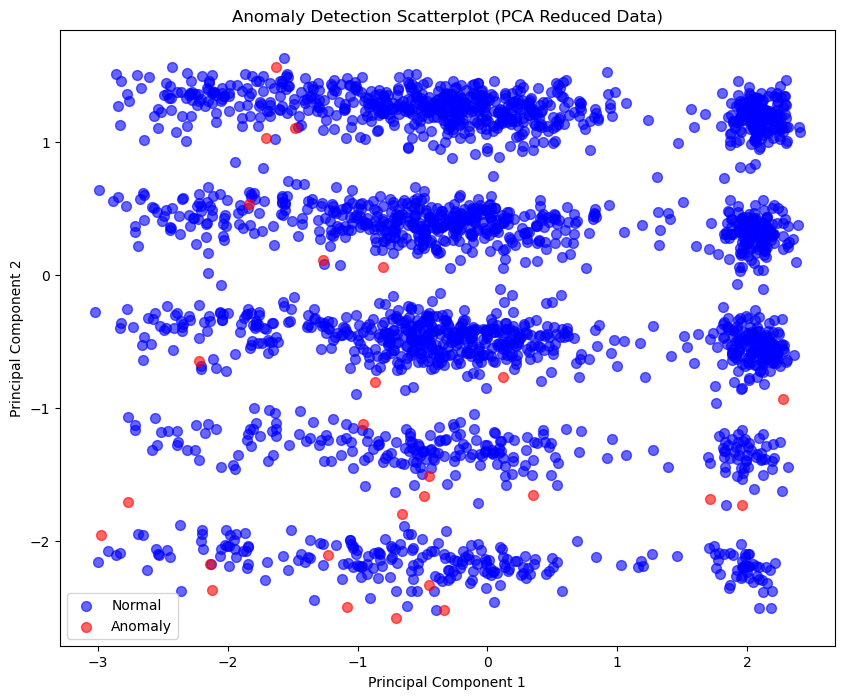

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the dimensionality to 2 components using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Add the PCA results to the data frame for plotting
data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]

# Create a scatterplot with different colors for anomalies (-1) and normal transactions (1)
plt.figure(figsize=(10, 8))
colors = {1: 'blue', -1: 'red'}
labels = {1: 'Normal', -1: 'Anomaly'}

for label in data['Anomaly'].unique():
    subset = data[data['Anomaly'] == label]
    plt.scatter(subset['PCA1'], subset['PCA2'],
                c=colors[label],
                label=labels[label],
                alpha=0.6, s=50)

plt.title("Anomaly Detection Scatterplot (PCA Reduced Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


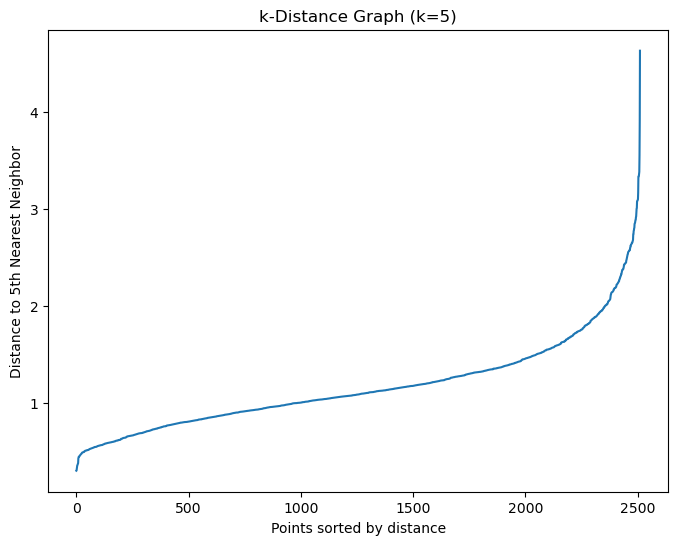

In [25]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Use min_samples (k) = 5
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_scaled)
distances, indices = neigh.kneighbors(X_scaled)
# Sort the distances to the 5th nearest neighbor (index 4)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title("k-Distance Graph (k=5)")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 5th Nearest Neighbor")
plt.show()


In [39]:
from sklearn.cluster import KMeans
import numpy as np

# Set the number of clusters (this may require tuning; an elbow plot can help)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Calculate distances of each point to its cluster centroid
distances = np.linalg.norm(X_scaled - centroids[cluster_labels], axis=1)

# Set a threshold (e.g., the 95th percentile)
threshold = np.percentile(distances, 95)

# Label anomalies: points with distance greater than threshold are anomalies (-1)
anomalies_kmeans = np.where(distances > threshold, -1, 1)
data['Anomaly_KMeans'] = anomalies_kmeans

print(f"KMeans: Detected {(data['Anomaly_KMeans'] == -1).sum()} anomalies out of {len(data)} transactions.")


KMeans: Detected 126 anomalies out of 2512 transactions.


In [27]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN (tune eps and min_samples based on your data)
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# In DBSCAN, noise is labeled as -1
data['Anomaly_DBSCAN'] = dbscan_labels

print(f"DBSCAN: Detected {(data['Anomaly_DBSCAN'] == -1).sum()} anomalies out of {len(data)} transactions.")


DBSCAN: Detected 96 anomalies out of 2512 transactions.


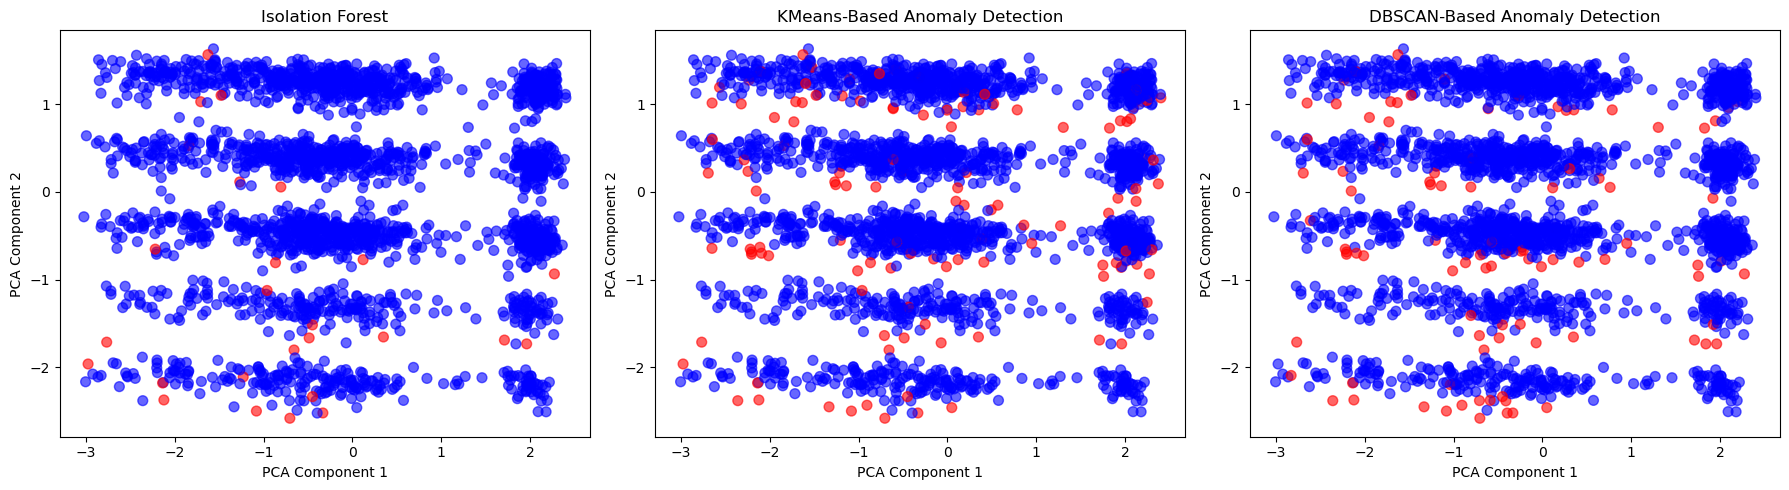

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]

# Define a function to plot the results
def plot_anomaly_scatter(df, anomaly_col, title):
    plt.scatter(df['PCA1'], df['PCA2'], 
                c=df[anomaly_col].apply(lambda x: 'red' if x == -1 else 'blue'),
                alpha=0.6, s=50)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plot_anomaly_scatter(data, 'Anomaly', "Isolation Forest")

plt.subplot(1, 3, 2)
plot_anomaly_scatter(data, 'Anomaly_KMeans', "KMeans-Based Anomaly Detection")

plt.subplot(1, 3, 3)
plot_anomaly_scatter(data, 'Anomaly_DBSCAN', "DBSCAN-Based Anomaly Detection")

plt.tight_layout()
plt.show()


Transactions flagged by all three methods: 23
Transactions flagged by at least two methods: 78
       TransactionAmount  CustomerAge  TransactionDuration  UniqueIPCount
count          23.000000    23.000000            23.000000      23.000000
mean          657.447391    49.478261           165.869565       6.652174
std           551.793090    17.077017            83.246788       2.756953
min             6.300000    18.000000            62.000000       2.000000
25%           173.355000    36.000000            90.500000       5.000000
50%           445.410000    54.000000           156.000000       6.000000
75%          1156.040000    61.500000           242.500000       8.500000
max          1831.020000    80.000000           297.000000      12.000000


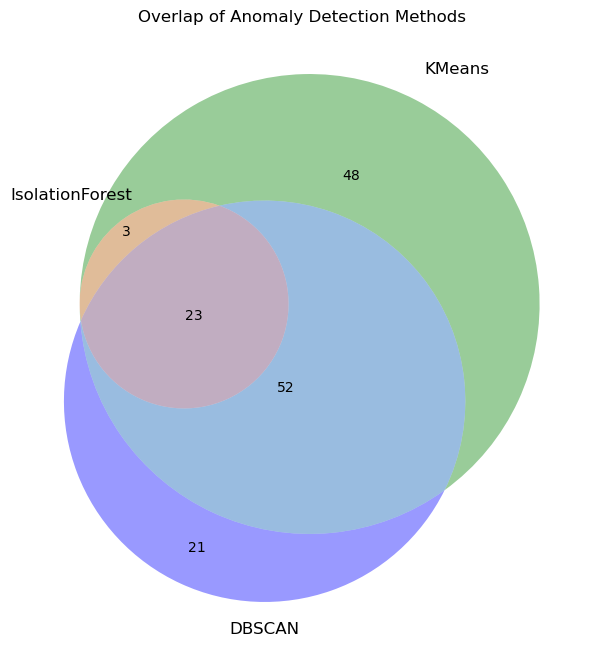

In [50]:
# Convert anomaly labels to binary flags: 1 if anomaly (-1), 0 if normal (1)
data['IF_anomaly'] = data['Anomaly'].apply(lambda x: 1 if x == -1 else 0)
data['KM_anomaly'] = data['Anomaly_KMeans'].apply(lambda x: 1 if x == -1 else 0)
data['DB_anomaly'] = data['Anomaly_DBSCAN'].apply(lambda x: 1 if x == -1 else 0)

# Compute the total anomaly flags per transaction
data['Total_Anomaly_Flags'] = data['IF_anomaly'] + data['KM_anomaly'] + data['DB_anomaly']

# Transactions flagged as anomalies by all three methods
all_three = data[data['Total_Anomaly_Flags'] == 3]
print(f"Transactions flagged by all three methods: {len(all_three)}")

# Transactions flagged as anomalies by at least two methods
at_least_two = data[data['Total_Anomaly_Flags'] >= 2]
print(f"Transactions flagged by at least two methods: {len(at_least_two)}")

# Optionally, display a quick summary of a few features for the transactions flagged by all three methods
print(all_three[['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'UniqueIPCount']].describe())

# ----------------------------------------------------------
# Plotting a Venn diagram to visualize the overlap
# ----------------------------------------------------------
# Ensure you have matplotlib_venn installed: pip install matplotlib-venn
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Create sets of indices for anomalies from each method
set_if = set(data[data['Anomaly'] == -1].index)
set_km = set(data[data['Anomaly_KMeans'] == -1].index)
set_db = set(data[data['Anomaly_DBSCAN'] == -1].index)

plt.figure(figsize=(8, 8))
venn3([set_if, set_km, set_db], set_labels = ('IsolationForest', 'KMeans', 'DBSCAN'))
plt.title("Overlap of Anomaly Detection Methods")
plt.show()


In [51]:
# Transactions with 2 or 3 anomaly flags are labeled as anomalies
data['Anomaly_AtLeastTwo'] = data['Total_Anomaly_Flags'].apply(lambda x: 1 if x >= 2 else 0)

# Count how many transactions are flagged by this approach
at_least_two_count = data['Anomaly_AtLeastTwo'].sum()
print(f"Number of transactions flagged as anomalies by at least two methods: {at_least_two_count}")


Number of transactions flagged as anomalies by at least two methods: 78


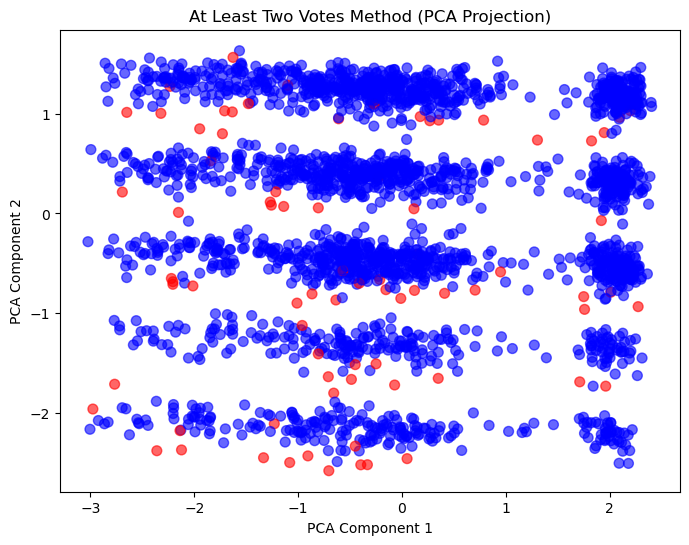

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Color code: red for anomalies, blue for normal
colors = data['Anomaly_AtLeastTwo'].map({0: 'blue', 1: 'red'})

plt.scatter(data['PCA1'], data['PCA2'], c=colors, alpha=0.6, s=50)
plt.title("At Least Two Votes Method (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


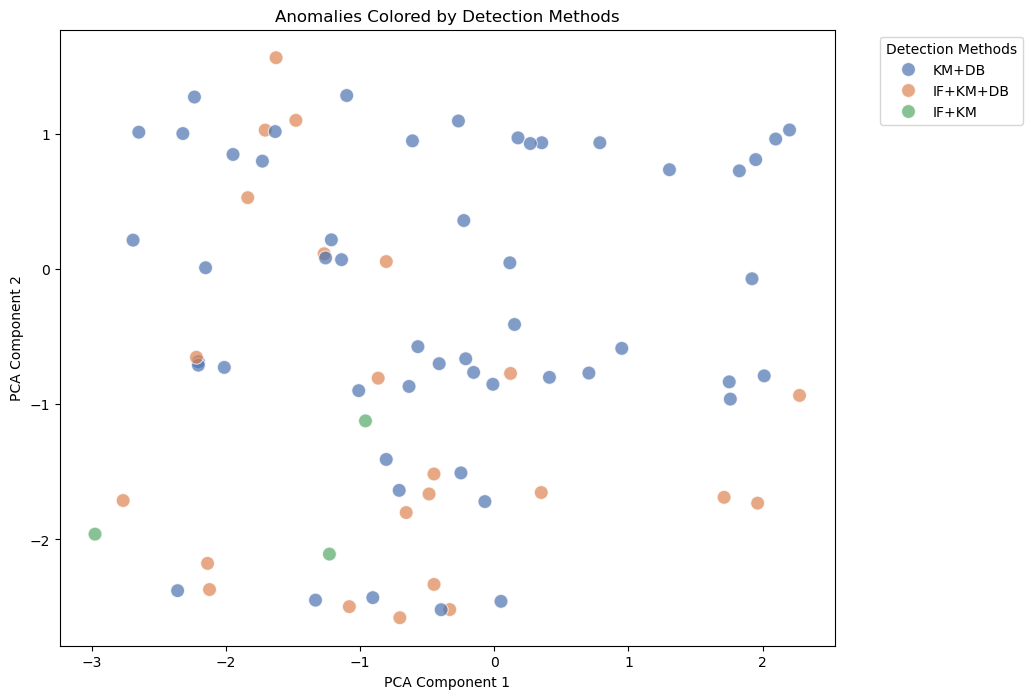

In [54]:
# Filter for transactions flagged by any method (Total_Anomaly_Flags > 0)
anomalies_all = data[data['Total_Anomaly_Flags'] > 1].copy()

# Create a new column that lists which methods flagged each anomaly
def get_anomaly_source(row):
    sources = []
    if row['IF_anomaly'] == 1:
        sources.append("IF")
    if row['KM_anomaly'] == 1:
        sources.append("KM")
    if row['DB_anomaly'] == 1:
        sources.append("DB")
    return "+".join(sources)

anomalies_all['Anomaly_Source'] = anomalies_all.apply(get_anomaly_source, axis=1)

# (Assuming you've already computed PCA components earlier)
# If not, you can do:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]
anomalies_all['PCA1'] = data.loc[anomalies_all.index, 'PCA1']
anomalies_all['PCA2'] = data.loc[anomalies_all.index, 'PCA2']

# Plot all anomalies colored by which models flagged them
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(data=anomalies_all, x='PCA1', y='PCA2', 
                hue='Anomaly_Source', palette="deep", s=100, alpha=0.7)
plt.title("Anomalies Colored by Detection Methods")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Detection Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [59]:
# Create a new column based on Total_Anomaly_Flags
def map_anomaly_group(x):
    if x == 0:
        return "Normal"
    elif x == 2:
        return "Anomaly_2_Votes"
    elif x == 3:
        return "Anomaly_3_Votes"
    else:
        return "Anomaly_1_Votes"  # for any anomalies with 1 vote or unexpected values

data['Anomaly_Group'] = data['Total_Anomaly_Flags'].apply(map_anomaly_group)

# Check the distribution of the groups
print(data['Anomaly_Group'].value_counts())


Anomaly_Group
Normal             2365
Anomaly_1_Votes      69
Anomaly_2_Votes      55
Anomaly_3_Votes      23
Name: count, dtype: int64


In [62]:
features_to_compare = ['TransactionAmount', 'UniqueIPCount', 'LoginAttempts', 'TransactionDuration']

group_stats = data.groupby('Anomaly_Group')[features_to_compare].describe()
print(group_stats)


                TransactionAmount                                          \
                            count        mean         std    min      25%   
Anomaly_Group                                                               
Anomaly_1_Votes              69.0  795.727826  568.853846  13.48  238.540   
Anomaly_2_Votes              55.0  427.932182  500.779289   1.93  101.625   
Anomaly_3_Votes              23.0  657.447391  551.793090   6.30  173.355   
Normal                     2365.0  276.529721  251.636366   0.26   79.760   

                                          UniqueIPCount            ...  \
                    50%      75%      max         count      mean  ...   
Anomaly_Group                                                      ...   
Anomaly_1_Votes  717.74  1360.67  1762.28          69.0  6.318841  ...   
Anomaly_2_Votes  194.85   600.50  1919.11          55.0  6.472727  ...   
Anomaly_3_Votes  445.41  1156.04  1831.02          23.0  6.652174  ...   
Normal          

C:\Users\kealankuar.wh\AppData\Local\Temp\ipykernel_37828\1676038216.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Anomaly_Group', y='LoginAttempts', data=data, palette='Set3')


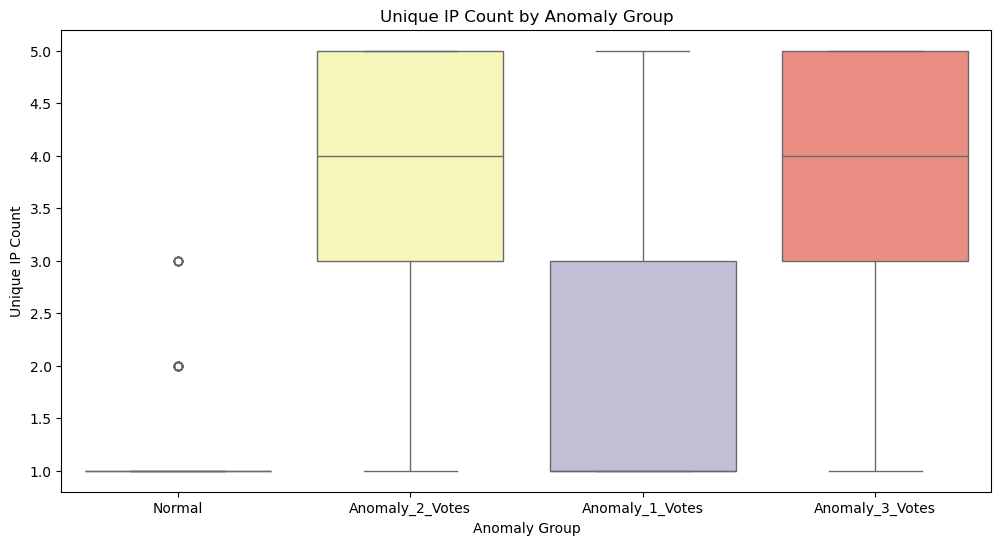

In [67]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Anomaly_Group', y='LoginAttempts', data=data, palette='Set3')
plt.title("Unique IP Count by Anomaly Group")
plt.xlabel("Anomaly Group")
plt.ylabel("Unique IP Count")
plt.show()
